In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, confusion_matrix
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import load_model
from tensorflow.python.keras.layers.kernelized import RandomFourierFeatures

import time

# Load data

In [2]:
data_dir = "data/classification/dr3"
def load_data(data_dir):
    list_5d = []
    list_6d = []
    for file in sorted(os.listdir(data_dir)):
        if "apg" in file:
            continue
        df = pd.read_csv(os.path.join(data_dir, file), index_col=0)
        if "5d" in file:
            list_5d.append(df)
        else:
            list_6d.append(df)
            
    df_5d = pd.concat(list_5d, axis=0, ignore_index=True)
    df_6d = pd.concat(list_6d, axis=0, ignore_index=True)
    return df_5d, df_6d

In [3]:
df_5d, df_6d = load_data(data_dir)

df_6d["class_6d"] = df_6d["class"]
df_6d["gm_p_high_6d"] = df_6d["gm_p_high"]

df = pd.merge(df_5d, df_6d[["Host", "class_6d", "gm_p_high_6d"]], on="Host")

In [4]:
df

,Host,n_40pc_stars,n_80pc_stars,densities_mean,densities_std,densities_max,densities_min,target_density,gm_p_low,gm_p_high,gm_mean_low,gm_mean_high,gm_cov_low,gm_cov_high,gm_aic,gm_bic,class,class_6d,gm_p_high_6d
0,3946945413106333696,3443,26653,1.076468,2.135811,3.482409,-5.707859,-1.050389,0.999867,1.333983e-04,-0.539928,0.163112,0.145671,0.068071,13.800443,3.800443,0,0,3.804340e-04
1,1696798367260229376,3265,24853,0.108761,0.241139,1.561548,-4.239513,0.158247,0.035972,9.640284e-01,-0.554736,0.161809,0.117110,0.053537,9.626222,-0.373778,2,2,9.728975e-01
2,1920113512486282240,4675,33889,0.054638,-0.055226,0.816202,-4.020925,-1.508119,1.000000,1.750919e-10,-0.552628,0.133321,0.103894,0.047933,20.785044,10.785044,0,0,4.883372e-12
3,1385293808145621504,5619,40586,0.204076,0.239566,1.128827,-9.474854,-0.396675,0.602565,3.974351e-01,-0.730741,0.240624,0.296076,0.118009,12.132933,2.132933,1,2,9.144478e-01
4,2135550755683407232,5701,40298,0.212517,0.253055,1.235413,-9.524719,-0.108797,0.231425,7.685754e-01,-0.721714,0.245230,0.307362,0.122374,11.081412,1.081412,1,2,9.638812e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526105,670652000741567744,409,3283,0.061897,-0.051001,0.581089,-2.689579,-0.579118,1.000000,3.861747e-07,-0.454725,0.251165,0.108808,0.021944,11.218556,1.218556,0,0,9.141424e-08
526106,664717249292148608,751,5907,0.106572,0.015236,0.771448,-3.523249,-0.048143,0.326439,6.735610e-01,-0.423018,0.225743,0.088641,0.047186,10.600629,0.600629,1,1,7.911486e-01
526107,668694659589432832,3272,25474,0.104653,0.042985,0.828242,-5.035431,0.314042,0.025002,9.749981e-01,-0.510541,0.223963,0.116814,0.053264,10.004015,0.004015,2,2,9.772940e-01
526108,667221318305572096,807,6489,0.094575,-0.005597,0.676754,-4.946747,-0.521848,0.991565,8.434647e-03,-0.487260,0.208795,0.095335,0.047555,11.421145,1.421145,0,0,1.092208e-02


# EDA

In [14]:
def label_groups(row):
    if row["class"] == 0 and row["class_6d"] == 2:
        return 0
    elif row["class"] == 2 and row["class_6d"] == 0:
        return 1
    elif row["class"] == 0 and row["class_6d"] == 1:
        return 2
    elif row["class"] == 1 and row["class_6d"] == 0:
        return 3
    elif row["class"] == 2 and row["class_6d"] == 1:
        return 4
    elif row["class"] == 1 and row["class_6d"] == 2:
        return 5
    elif row["class"] == 0 and row["class_6d"] == 0:
        return 6
    elif row["class"] == 1 and row["class_6d"] == 1:
        return 7
    elif row["class"] == 2 and row["class_6d"] == 2:
        return 8

In [15]:
def pie_groups(row):
    if row["class_group"] <= 1:
        return 0
    elif 5 >= row["class_group"] >= 2:
        return 1
    else:
        return 2

In [16]:
df["class_group"] = df.apply(lambda row: label_groups(row), axis=1)
groups = ["5d low density - 6d high density", "6d low density - 5d high density",
          "5d low density - 6d ambigous", "5d ambigous - 6d low density",
          "5d high density - 6d ambigous", "5d ambigous - 6d high density",
          "5d low density - 6d low density", "5d ambigous - 6d ambigous",
          "5d high density - 6d high density"]

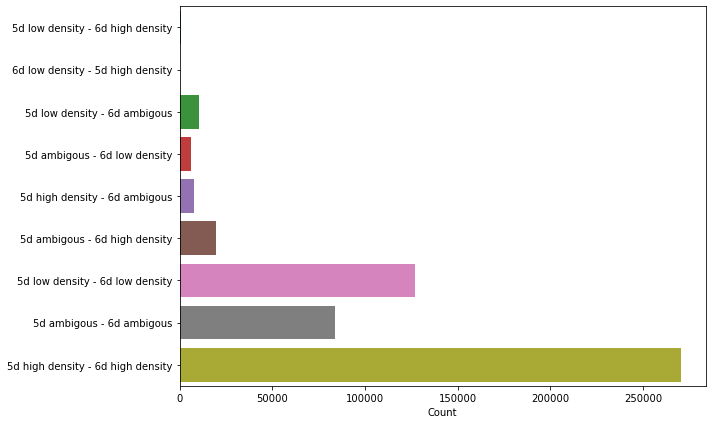

In [17]:
pie, ax = plt.subplots(figsize=[10,6], facecolor="w")
ax = sns.countplot(y=df["class_group"])
ax.set_yticklabels(labels=groups)
plt.ylabel("")
plt.xlabel("Count")
plt.tight_layout()
plt.savefig("report_images/density_class_prediction_breakdown.png");

In [18]:
df["pie_group"] = df.apply(lambda row: pie_groups(row), axis=1)
outs = df[df["pie_group"] == 0]["Host"]
pie_groups = ["Matching classes", "Missmatched as ambigous", "Mismatched density classes"]

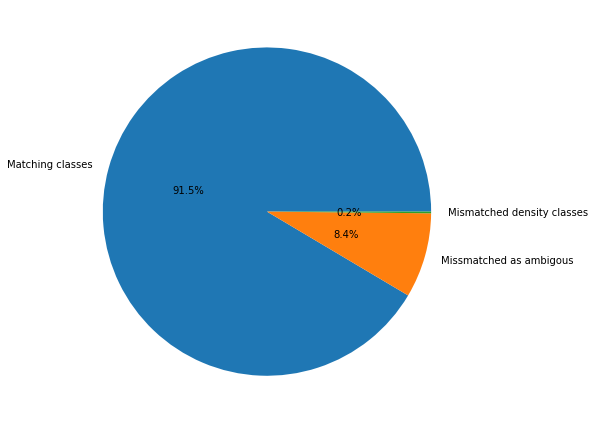

In [19]:
pie, ax = plt.subplots(figsize=[9,6], facecolor="w")
plt.pie(x=df["pie_group"].value_counts(), autopct="%.1f%%", labels=pie_groups, pctdistance=0.5)
plt.title("", fontsize=14)
plt.tight_layout()
plt.savefig("report_images/density_class_prediction_comparison.png", bbox_inches = "tight");

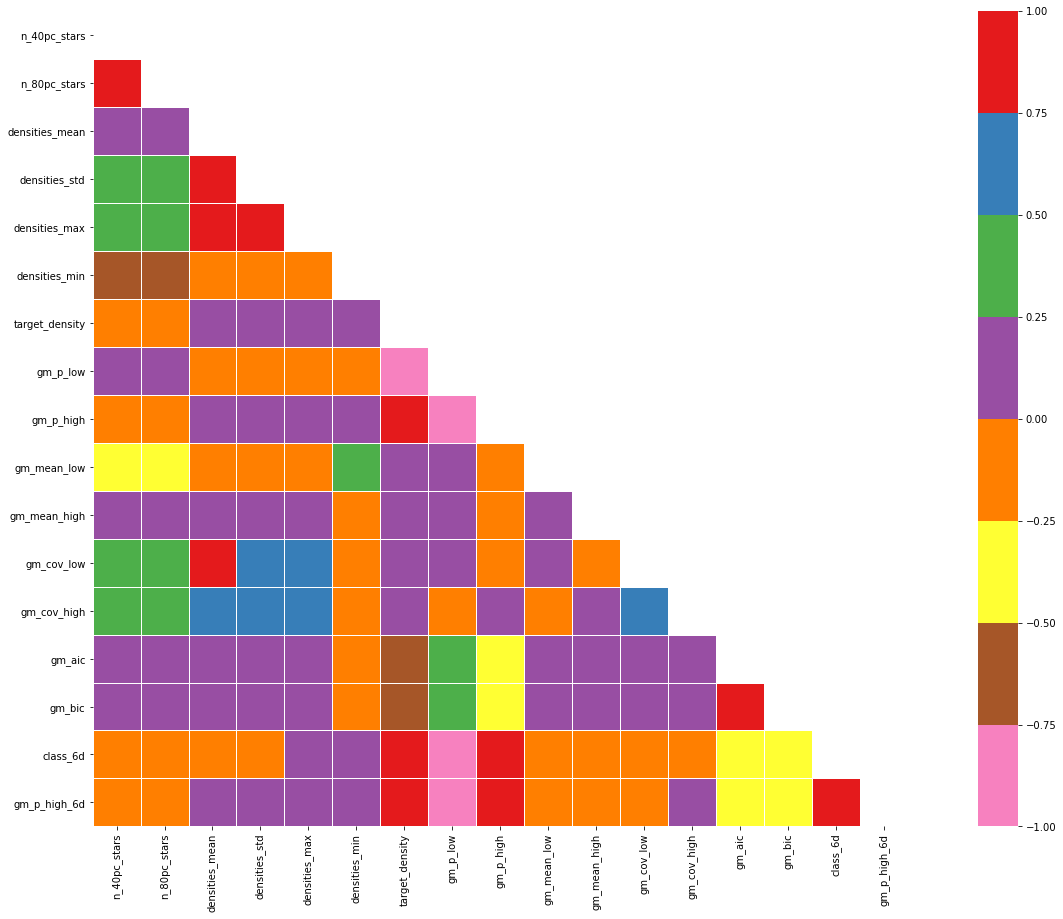

In [55]:
plt.figure(figsize=(25, 15), facecolor="white")
mask = np.triu(np.ones_like(df.drop(["Host", "class"], axis=1).corr(), dtype=bool))
cmap = ['#f781bf', '#a65628', '#ffff33', '#ff7f00', '#984ea3', '#4daf4a', '#377eb8','#e41a1c']
sns.heatmap(df.drop(["Host", "class"], axis=1).corr(), mask=mask, vmin=-1, vmax=1, cmap=cmap,square=True, linewidths=.5, annot=False)
plt.savefig("report_images/corr_graph.png", bbox_inches="tight", pad_inches=0.05);

# Helping functions for model training

### Encoding data for neural networks

In [5]:
def encode_for_nn(y_train, y_val=None):
    depth = tf.constant(3)
    y_train = tf.one_hot(indices=y_train, depth=depth)
    if y_val is None:
        return y_train
    y_val = tf.one_hot(indices=y_val, depth=depth)
    
    return y_train, y_val#, y_test

### Scaling data for convolutional neural network input

In [6]:
def cnn_scale(x_train, x_val, x_test):
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
    
    return x_train, x_val, x_test

### Create train/test sets

In [7]:
def split_data(train_df, regression=False):
    
    if regression:
        output = train_df["gm_p_high_6d"]
    else:
        output = train_df["class_6d"]
    
    x_train = train_df.iloc[20047:, :]
    y_train = output[20047:]
    x_test = train_df.iloc[:20047, :]
    y_test = output[:20047]

    hosts = x_test["Host"]
    x_train = x_train[["target_density", "densities_max", "densities_min", "densities_mean", "gm_cov_high", "gm_mean_high"]]
    x_test = x_test[["target_density", "densities_max", "densities_min", "densities_mean", "gm_cov_high", "gm_mean_high"]]

    return x_train, x_test, y_train, y_test, hosts

### Return classification performance metrics of the model

In [8]:
def get_scores(model, model_name, features, params, x_test, y_test, hosts, train_time, columns):

    start = time.perf_counter()
    if "Random Forest" in model_name:
        predictions = model.predict(x_test)
    else:
        predictions = np.argmax(model.predict(x_test), axis=-1)
    end = time.perf_counter()
    pred_time = end-start

    test_accuracy = accuracy_score(y_test, predictions)
    test_precision = precision_score(y_test, predictions, average="macro")
    test_recall = recall_score(y_test, predictions, average="macro")
    test_f1 = f1_score(y_test, predictions, average="macro")
    
    df = pd.DataFrame([[model_name, features, params, test_accuracy, test_precision, test_recall, test_f1, train_time, pred_time]], columns=columns)
    return df, predictions

### Return regression performance metrics

In [9]:
def get_reg_scores(model, model_name, features, params, x_test, y_test, hosts, train_time, columns):

    start = time.perf_counter()
    
    predictions = model.predict(x_test)
 
    end = time.perf_counter()
    pred_time = end-start

    mse_score = mse(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    df = pd.DataFrame([[model_name, features, params, mse_score, r2, train_time, pred_time]], columns=columns)
    return df, predictions

### Random Forest model setups

In [10]:
# Classification
def rfc(x_train, y_train):
    model = RandomForestClassifier()
    old = model.get_params()
    model.set_params(n_estimators=100, max_depth=25, class_weight="balanced", n_jobs=-1)
    new = model.get_params()
    
    start = time.perf_counter()
    model.fit(x_train, y_train)
    end = time.perf_counter()
    t = end-start
    
    params = {k: new[k] for k in new if k in old and new[k] != old[k]}
    
    return model, params, t, "Random Forest"

In [11]:
# Regression
def rfr(x_train, y_train):
    model = RandomForestRegressor()
    old = model.get_params()
    model.set_params(n_jobs=-1)
    new = model.get_params()
    
    start = time.perf_counter()
    model.fit(x_train, y_train)
    end = time.perf_counter()
    t = end-start
    
    params = {k: new[k] for k in new if k in old and new[k] != old[k]}
    
    return model, params, t, "Random Forest"

### Convolutional neural network architectures

In [12]:
# Classification
def cnn_1d(x_train, y_train, x_val, y_val):
    params = []
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    stopper = EarlyStopping(monitor='val_loss', patience=5)
    n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], 3
    activation = "relu"
    epochs = 100
    
    model = Sequential()
    model.add(Input(shape=(n_timesteps, n_features)))
    params.append(f"Input: ({n_timesteps}, {n_features})")
    model.add(Conv1D(filters=256, kernel_size=4, activation=activation))
    params.append(f"Conv1D: filters=256, kernel_size=4, activation={activation}")

    model.add(MaxPooling1D(pool_size=3))
    params.append(f"MaxPooling1D: pool_size=3")
    model.add(Flatten())
    params.append(f"Flatten")
    model.add(Dense(units=128, activation=activation))
    params.append(f"Dense: units=128, activation={activation}")
    model.add(Dense(units=64, activation=activation))
    params.append(f"Dense: units=64, activation={activation}")
    model.add(Dense(units=3, activation='softmax'))
    params.append(f"Dense: units=3, activation=softmax")
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['categorical_accuracy'])
    params.append(f"Compile: Optimizer=Adam(learning_rate=0.0001), loss=categorical_crossentropy, metrics=categorical_accuracy")
    params.append(f"Args: Epochs={epochs}, Callbacks=EarlyStopping(monitor='val_loss', patience=5)")
    
    start = time.perf_counter()
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=stopper, verbose=0)
    end = time.perf_counter()
    t = end-start
    
    return model, params, t, "1dCNN"

In [13]:
# Regression
def cnn_1d_reg(x_train, y_train, x_val, y_val, params):
    tf.keras.callbacks.History()
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    stopper = EarlyStopping(monitor='val_loss', patience=5)
    n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], 1
    activation = "relu"
    epochs = 100
    
    model = Sequential()
    model.add(Input(shape=(n_timesteps, n_features)))
    params.append(f"Input: ({n_timesteps}, {n_features})")
    model.add(Conv1D(filters=256, kernel_size=4, activation=activation))
    params.append(f"Conv1D: filters=256, kernel_size=4, activation={activation}")
    model.add(Conv1D(filters=32, kernel_size=3, activation=activation))
    params.append(f"Conv1D: filters=32, kernel_size=3, activation={activation}")
    model.add(MaxPooling1D(pool_size=3))
    params.append(f"MaxPooling1D: pool_size=3")
    model.add(Flatten())
    params.append(f"Flatten")
    model.add(Dense(units=64, activation=activation))
    params.append(f"Dense: units=64, activation={activation}")
    model.add(Dense(units=32, activation=activation))
    params.append(f"Dense: units=32, activation={activation}")

    model.add(Dense(units=n_outputs))
    params.append(f"Dense: units={n_outputs}")
    model.compile(optimizer=opt, loss="mse")
    params.append(f"Compile: Optimizer=Adam(learning_rate=0.0001), loss=mse")
    params.append(f"Args: Epochs={epochs}, Callbacks=EarlyStopping(monitor='val_loss', patience=5)")
    
    start = time.perf_counter()
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=stopper, verbose=0)
    end = time.perf_counter()
    t = end-start
    
    return model, history, params, t, "1dCNN"

### Classification neural network with RFF layer architecture

In [14]:
# Classification
def ann(x_train, y_train):
    params = []
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    stopper = EarlyStopping(monitor='val_loss', patience=5)
    n_features = x_train.shape[1]
    activation = "relu"
    epochs = 100
    
    model = tf.keras.Sequential()
    model.add(Input(shape=(n_features, )))
    params.append(f"Input: ({n_features}, )")
    model.add(RandomFourierFeatures(output_dim=16384, scale=3., kernel_initializer='laplacian'))
    params.append(f"RandomFourierFeatures: output_dim=16384, scale=3., kernel_initializer=laplacian")
    
    model.add(Dense(units=64, activation=activation))
    params.append(f"Dense: units=128")
    model.add(Dense(units=16, activation=activation))
    params.append(f"Dense: units=64")
    
    model.add(Dense(units=3, activation='softmax'))
    params.append(f"Dense: units=3, activation=softmax")
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    params.append(f"Compile: Optimizer=Adam(learning_rate=0.0001), loss=categorical_crossentropy, metrics=categorical_accuracy")
    params.append(f"Args: Epochs={epochs}, Callbacks=EarlyStopping(monitor='val_loss', patience=5)")
    
    start = time.perf_counter()
    model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, callbacks=stopper, verbose=0)
    end = time.perf_counter()
    t = end-start
    
    params.append(f"Validation split: 0.1")
    
    return model, params, t, "ANN"

In [15]:
# Regression
def ann_reg(x_train, y_train):
    tf.keras.callbacks.History()
    params = []
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    stopper = EarlyStopping(monitor='val_loss', patience=5)
    n_features = x_train.shape[1]
    activation = "relu"
    epochs = 100
    
    model = tf.keras.Sequential()
    model.add(Input(shape=(n_features, )))
    params.append(f"Input: ({n_features}, )")
    model.add(RandomFourierFeatures(output_dim=16384, scale=2., kernel_initializer='laplacian'))
    params.append(f"RandomFourierFeatures: output_dim=16384, scale=2., kernel_initializer=laplacian")
    
    model.add(Dense(units=64, activation=activation))
    params.append(f"Dense: units=64")
    model.add(Dense(units=16, activation=activation))
    params.append(f"Dense: units=16")
    
    model.add(Dense(units=1))
    params.append(f"Dense: units=1")
    model.compile(optimizer=opt, loss="mse")
    params.append(f"Compile: Optimizer=Adam(learning_rate=0.0001), loss=mse")
    params.append(f"Args: Epochs={epochs}, Callbacks=EarlyStopping(monitor='val_loss', patience=5)")
    
    start = time.perf_counter()
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, callbacks=stopper, verbose=0)
    end = time.perf_counter()
    t = end-start
    
    params.append(f"Validation split: 0.1")
    
    return model, history, params, t, "ANN"

# Classification models training

### Each training session is done 10 times and the mean of all results is saved

In [27]:
columns = ["Classifier", "Features", "Parameters", "Accuracy", "Precision", "Recall", "F1-score", "Train Duration", "Predict Duration"]
set_size = df_5d.shape[0]
results_dir = "results/classification"
results_file = "results" + "_" + str(set_size) + ".csv"
iters = 1
results = pd.DataFrame(columns=columns)

### Random Forest training pipeline

In [62]:
def train_rf(results):
    scores = pd.DataFrame(columns=columns)
    best_score = 0
    best_pred = None
    best_model = None

    j = 0
    for file in os.listdir("saved_models"):
        if "RF_model" in file:
            j += 1

    for i in range(iters):
        x_train, x_test, y_train, y_test, hosts = split_data(df)
        features = x_test.columns.values
        model, params, train_time, model_name = rfc(x_train, y_train)
        model_name = model_name + f" {str(j)}"
        score, predictions = get_scores(model, model_name, features, params, x_test, y_test, hosts, train_time, columns)
        scores = scores.append(score, ignore_index=True)
        if score["F1-score"][0] > best_score:
            best_score = score["F1-score"][0]
            best_pred = predictions
            best_model = model

    cm = confusion_matrix(y_test, best_pred)

    fig = plt.figure(figsize=(7, 7), facecolor="w")
    ticklabels = ["Underdensity", "Ambigous", "Overdensity"]
    sns.heatmap(cm, yticklabels=ticklabels, xticklabels=ticklabels, cmap="viridis", center=0, annot=True, fmt='g', cbar=False, annot_kws={"size": 15})
    plt.savefig(f"report_images/RF_matrix_{j}.png")
    plt.close()
    pickle.dump(best_model, open(f"saved_models/RF_model_{j}.sav", "wb"))

    results = results.append([pd.concat([scores.iloc[0, :3], scores.mean()], axis=0)])
    
    return results

In [ ]:
results = train_rf(results)

### 1dCNN training pipeline

In [89]:
def train_1dcnn(results):
    scores = pd.DataFrame(columns=columns)
    best_score = 0
    best_pred = None
    best_model = None
    best_history = None
    
    j = 0
    for file in os.listdir("saved_models/1DCNN"):
        if "1DCNN_model" in file:
            j += 1
    
    for i in range(iters):
        params = []
        x_train, x_test, y_train, y_test, hosts = split_data(df)
        features = x_test.columns.values
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
        params.append("Validation split: 0.2")
        y_train, y_val = encode_for_nn(y_train, y_val)
        x_train, x_val, x_test = cnn_scale(x_train, x_val, x_test)
        model, history, params, train_time, model_name = cnn_1d(x_train, y_train, x_val, y_val, params)
        model_name = model_name + f" {str(j)}"
        score, predictions = get_scores(model, model_name, features, params, x_test, y_test, hosts, train_time, columns)
        scores = scores.append(score, ignore_index=True)
        if score["F1-score"][0] > best_score:
            best_score = score["F1-score"][0]
            best_pred = predictions
            best_model = model
            best_history = history

    cm = confusion_matrix(y_test, best_pred)
    fig = plt.figure(figsize=(7, 5), facecolor="w")
    ticklabels = ["Underdensity", "Ambigous", "Overdensity"]
    sns.heatmap(cm, yticklabels=ticklabels, xticklabels=ticklabels, cmap="viridis", center=0, annot=True, fmt='g', cbar=False, annot_kws={"size": 15})
    plt.savefig(f"report_images/1DCNN/1DCNN_matrix_{j}.png")
    #plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(7, 5), facecolor="w")
    plt.plot(best_history.history['categorical_accuracy'])
    plt.plot(best_history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0.89, 0.935)
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(f"report_images/1DCNN/1DCNN_accuracy_{j}.png")
    #plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(7, 5), facecolor="w")
    plt.plot(best_history.history['loss'])
    plt.plot(best_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0.16, 0.26)
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(f"report_images/1DCNN/1DCNN_loss_{j}.png")
    plt.close()
    model.save(f"saved_models/1DCNN/1DCNN_model_{j}")

    results = results.append([pd.concat([scores.iloc[0, :3], scores.mean()], axis=0)])
    
    return results

In [ ]:
results = train_1dcnn(results)

### ANN training pipeline

In [83]:
def train_ann(results):
    scores = pd.DataFrame(columns=columns)
    best_score = 0
    best_pred = None
    best_model = None
    best_history = None
    
    j = 0
    for file in os.listdir("saved_models/ANN"):
        if "ANN_model" in file:
            j += 1
    
    for i in range(iters):
        x_train, x_test, y_train, y_test, hosts = split_data(df)
        features = x_test.columns.values
        y_train= encode_for_nn(y_train)
        model, history, params, train_time, model_name = ann(x_train, y_train)
        model_name = model_name + f" {str(j)}"
        score, predictions = get_scores(model, model_name, features, params, x_test, y_test, hosts, train_time, columns)
        scores = scores.append(score, ignore_index=True)
        if score["F1-score"][0] > best_score:
            best_score = score["F1-score"][0]
            best_pred = predictions
            best_model = model
            best_history = history

    cm = confusion_matrix(y_test, best_pred)
    fig = plt.figure(figsize=(7, 5), facecolor="w")
    ticklabels = ["Underdensity", "Ambigous", "Overdensity"]
    sns.heatmap(cm, yticklabels=ticklabels, xticklabels=ticklabels, cmap="viridis", center=0, annot=True, fmt='g', cbar=False, annot_kws={"size": 15})
    plt.savefig(f"report_images/ANN/ANN_matrix_{j}.png")
    plt.close()
    
    fig = plt.figure(figsize=(7, 5), facecolor="w")
    plt.plot(best_history.history['categorical_accuracy'])
    plt.plot(best_history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0.89, 0.935)
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(f"report_images/ANN/ANN_accuracy_{j}.png")
    plt.close()
    
    fig = plt.figure(figsize=(7, 5), facecolor="w")
    plt.plot(best_history.history['loss'])
    plt.plot(best_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0.16, 0.26)
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(f"report_images/ANN/ANN_loss_{j}.png")
    plt.close()
    
    model.save(f"saved_models/ANN/ANN_model_{j}")

    results = results.append([pd.concat([scores.iloc[0, :3], scores.mean()], axis=0)])
    
    return results

In [ ]:
results = train_ann(results)

### Save classification results

In [148]:
if Path(os.path.join(results_dir, results_file)).is_file():
    results.to_csv(os.path.join(results_dir, results_file), mode='a', header=False, index=False)
else:
    results.to_csv(os.path.join(results_dir, results_file), index=False)

# Regression models training

In [16]:
columns = ["Regressor", "Features", "Parameters", "MSE", "R2 score", "Train Duration", "Predict Duration"]
set_size = df_5d.shape[0]
results_dir = "results/regression"
results_file = "results" + "_" + str(set_size) + ".csv"
iters = 1
results = pd.DataFrame(columns=columns)

### Random Forest training pipeline

In [17]:
def train_rf(results):
    scores = pd.DataFrame(columns=columns)
    best_score = 0
    best_pred = None
    best_model = None

    j = 0
    for file in os.listdir("saved_models/RFR"):
        if "RF_model" in file:
            j += 1
    
    for i in range(iters):
        x_train, x_test, y_train, y_test, hosts = split_data(df, regression=True)
        features = x_test.columns.values
        model, params, train_time, model_name = rfr(x_train, y_train)
        model_name = model_name + f" {str(j)}"
        score, predictions = get_reg_scores(model, model_name, features, params, x_test, y_test, hosts, train_time, columns)
        scores = scores.append(score, ignore_index=True)
        if score["R2 score"][0] > best_score:
            best_score = score["R2 score"][0]
            best_pred = predictions
            best_model = model

    fig = plt.figure(figsize=(7, 5), facecolor="w")
    plt.scatter(y_test, predictions)
    plt.xlabel("Prediction")
    plt.ylabel("Ground truth")
    plt.savefig(f"report_images/RFR/RF_loss_{j}.png")
    plt.close()
    
    pickle.dump(best_model, open(f"saved_models/RFR/RF_model_{j}.sav", "wb"))

    results = results.append([pd.concat([scores.iloc[0, :3], scores.mean()], axis=0)])
    
    return results

In [ ]:
results = train_rf(results)

In [166]:
def train_1dcnn(results):
    scores = pd.DataFrame(columns=columns)
    best_score = 0
    best_pred = None
    best_model = None
    best_history = None
    
    j = 0
    for file in os.listdir("saved_models/1DCNN_reg"):
        if "1DCNN_model" in file:
            j += 1
    
    for i in range(iters):
        params = []
        x_train, x_test, y_train, y_test, hosts = split_data(df, regression=True)
        features = x_test.columns.values
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
        params.append("Validation split: 0.2")
        x_train, x_val, x_test = cnn_scale(x_train, x_val, x_test)
        model, history, params, train_time, model_name = cnn_1d_reg(x_train, y_train, x_val, y_val, params)
        model_name = model_name + f" {str(j)}"
        score, predictions = get_reg_scores(model, model_name, features, params, x_test, y_test, hosts, train_time, columns)
        scores = scores.append(score, ignore_index=True)
        if score["R2 score"][0] > best_score:
            best_score = score["R2 score"][0]
            best_pred = predictions
            best_model = model
            best_history = history
    
    fig = plt.figure(figsize=(7, 5), facecolor="w")
    plt.scatter(y_test, predictions)
    plt.xlabel("Prediction")
    plt.ylabel("Ground truth")
    plt.savefig(f"report_images/1DCNN_reg/1DCNN_preds_{j}.png")
    plt.close()
    
    fig = plt.figure(figsize=(7, 5), facecolor="w")
    plt.plot(best_history.history['loss'])
    plt.plot(best_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(f"report_images/1DCNN_reg/1DCNN_loss_{j}.png")
    plt.close()
    model.save(f"saved_models/1DCNN_reg/1DCNN_model_{j}")

    results = results.append([pd.concat([scores.iloc[0, :3], scores.mean()], axis=0)])
    
    return results

In [ ]:
results = train_1dcnn(results)

In [18]:
def train_ann(results):
    scores = pd.DataFrame(columns=columns)
    best_score = 0
    best_pred = None
    best_model = None
    best_history = None
    
    j = 0
    for file in os.listdir("saved_models/ANN_reg"):
        if "ANN_model" in file:
            j += 1
    
    for i in range(iters):
        x_train, x_test, y_train, y_test, hosts = split_data(df, regression=True)
        features = x_test.columns.values
        model, history, params, train_time, model_name = ann_reg(x_train, y_train)
        model_name = model_name + f" {str(j)}"
        score, predictions = get_reg_scores(model, model_name, features, params, x_test, y_test, hosts, train_time, columns)
        scores = scores.append(score, ignore_index=True)
        if score["R2 score"][0] > best_score:
            best_score = score["R2 score"][0]
            best_pred = predictions
            best_model = model
            best_history = history

    fig = plt.figure(figsize=(7, 5), facecolor="w")
    plt.scatter(y_test, predictions)
    plt.xlabel("Prediction")
    plt.ylabel("Ground truth")
    plt.savefig(f"report_images/ANN_reg/ANN_preds_{j}.png")
    plt.close()
    
    fig = plt.figure(figsize=(7, 5), facecolor="w")
    plt.plot(best_history.history['loss'])
    plt.plot(best_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(f"report_images/ANN_reg/ANN_loss_{j}.png")
    plt.close()
    model.save(f"saved_models/ANN_reg/ANN_model_{j}")
    
    results = results.append([pd.concat([scores.iloc[0, :3], scores.mean()], axis=0)])
    
    return results

In [21]:
results = train_ann(results)

2021-09-15 12:52:51.472921: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-09-15 12:52:51.516655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 12:52:51.517227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:1c:00.0 name: GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.86GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2021-09-15 12:52:51.517520: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-09-15 12:52:51.518996: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-15 12:52:51.520763: I tensorflow/stream_executor/platform/de

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/ANN_reg/ANN_model_13/assets


### Save regression results

In [148]:
if Path(os.path.join(results_dir, results_file)).is_file():
    results.to_csv(os.path.join(results_dir, results_file), mode='a', header=False, index=False)
else:
    results.to_csv(os.path.join(results_dir, results_file), index=False)